In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# utils

In [20]:
def alpha_transform(data: pd.DataFrame, col: str, max_value: float):
    data = data.reset_index().set_index("date")
    data["mean"] = data.groupby("date")[col].mean()
    data["std"] = data.groupby("date")[col].std()
    data["zscore"] = np.minimum(max_value,np.maximum(-max_value,(data[col] - data["mean"]) / data["std"])).fillna(0)
    data = data.reset_index()
    return data["zscore"]


def feature_clip(x, col, qmin, qmax):
    return x[col].clip(x[col].quantile(qmin),x[col].quantile(qmax))

## Get data

In [4]:
import pyarrow.parquet as pq

# Specify the path to your parquet.gzip file
parquet_file_path = '../data/hf_netflow.parquet.gzip'

# Read the Parquet file using pyarrow
net_flow = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
net_flow = net_flow.to_pandas()

net_flow.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,tgainret,netflows,turnover1,turnover2,turnover3
0,2015-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,230.559108,-0.000580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,226.166607,-0.077177,220.872751,0.000000,-17.778290,-0.080491,-4.258772,0.000000,0.018471,0.939516
2,2015-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,206.563771,0.031058,8.114555,5.910309,-0.986499,-0.070339,-2.148021,0.027316,0.035630,0.052514
3,2015-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,203.341691,0.037110,5.266832,8.467398,-0.931106,-0.067795,-9.637487,0.025698,0.072154,0.019833
4,2016-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,214.631618,0.042093,7.935235,2.598843,0.324678,0.030822,3.743941,0.012435,0.031193,0.033393


In [5]:
# Specify the path to your parquet.gzip file
parquet_file_path = '../data/holdings_all.parquet.gzip'

# Read the Parquet file using pyarrow
holdings = pq.read_table(parquet_file_path)

# Convert the table to a Pandas DataFrame if needed
holdings = holdings.to_pandas()

# merge with net flow
# holdings.rename(columns = {'date': 'rdate'}, inplace=True)
# holdings = holdings.merge(net_flow[['rdate', 'mgrno', 'assets']], on=['rdate', 'mgrno'], how='left')

# set index
holdings = holdings.set_index(['date', 'mgrno', 'permno'])

holdings.head()

,,,first_report,last_report,shares,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno,...,askhi,bidlo,ret,shrout,yyyy-mm,gics,comnam,ticker,gics1,gics2
date,mgrno,permno,,,,,,,,,,,,,,,,,,,,,
2021-06-30,110.0,10104.0,False,False,3000.0,3000.0,2021-03-31,3000.0,0.0,1,NaN,10104.0,...,78.209999,77.580002,-0.003329,2792000.0,2021-06,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
2021-09-30,110.0,10104.0,False,False,3000.0,3000.0,2021-06-30,3000.0,0.0,1,10104.0,10104.0,...,91.580002,87.120003,-0.045151,2733686.0,2021-09,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
2021-12-31,110.0,10104.0,False,False,3000.0,3000.0,2021-09-30,3000.0,0.0,1,10104.0,10104.0,...,88.099998,87.180000,-0.009090,2670447.0,2021-12,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
2022-03-31,110.0,10104.0,False,False,3000.0,3000.0,2021-12-31,3000.0,0.0,1,10104.0,10104.0,...,83.910004,82.589996,-0.007558,2668157.0,2022-03,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services
2022-06-30,110.0,10104.0,False,False,3000.0,3000.0,2022-03-31,3000.0,0.0,1,10104.0,10107.0,...,70.250000,68.209999,0.009536,2664926.0,2022-06,45103020.0,ORACLE SYSTEMS CORP,ORCL,Information Technology,Software & Services


## time series change of holdings: per manager, per stock

1. buysale: buy = 1, sale = -1 (terminal sale should be fixed)
2. weight: value of a stock / value of the whole portfolio of this institution
3. weight_diff: quarterly difference of stock weight in the portfolio of this institution
4. share_chg: percentage change of share holdings on a stock of this institution
5. value_chg: percentage change of value holdings on a stock of this institution


In [7]:
# signal 1: buysale
# holdings['buysale'] = np.where(holdings['buysale']==1, holdings['buysale']*10, holdings['buysale']) # scale the initial buy
holdings.loc[holdings.index.get_level_values(0) == holdings.index.get_level_values(0).min(), 'buysale'] = 0  # the start of data cannot be treated as initial buy
holdings['buysale'] = np.sign(holdings['buysale'])

# signal 2: weight and weight diff
holdings['value'] = holdings['shares']*holdings['prc']
holdings['portfolio_value'] = holdings.groupby(['date', 'mgrno'])['value'].transform('sum')
holdings['weight'] = holdings['value'] / holdings['portfolio_value']
holdings['weight_diff'] = holdings.groupby(['mgrno', 'permno'])['weight'].diff()
holdings['weight_diff'] = np.where(holdings['buysale']==1, holdings['weight'], holdings['weight_diff'])

# noise: trade_dollar / value of the whole portfolio of this institution
holdings['trade_dollar'] = holdings['trade'] * holdings['prc']
holdings['trade_dollar_pct'] = holdings['trade_dollar'] / holdings['portfolio_value']

# signal 3: value change
holdings['share_chg'] = holdings['trade'] / (holdings['shares'] - holdings['trade'])
holdings['value_chg'] = holdings.groupby(['mgrno', 'permno'])['value'].pct_change()

## time series change of holdings: per stock

In [8]:
# signal 4: mgr cnt ratio change
#shares_ratio = holdings.groupby(['date', 'permno']).agg({'shares':'sum', 'shrout':'mean'})
#shares_ratio['mgr_shares_ratio'] = shares_ratio['shares'] / shares_ratio['shrout']
mgrno_cnt = holdings.reset_index().set_index(['date', 'permno']).groupby(['date', 'permno'])['mgrno'].count()
mgrno_cnt.name = 'mgrno_cnt'
total_mgrno_cnt = holdings.reset_index().groupby(['date'])['mgrno'].count()
total_mgrno_cnt.name = 'total_mgrno_cnt'
mgrno_cnt = total_mgrno_cnt.to_frame().join(mgrno_cnt)
mgrno_cnt['mgrno_cnt_ratio'] = mgrno_cnt['mgrno_cnt'] / mgrno_cnt['total_mgrno_cnt']
mgrno_cnt['mgrno_cnt_ratio_chg'] = mgrno_cnt.groupby('permno')['mgrno_cnt_ratio'].pct_change()
mgrno_cnt['mgrno_cnt_ratio_chg'].replace([np.inf, -np.inf], 0, inplace=True)

# signal 3: value change
# take log
# bug: negative prc
total_value = holdings.groupby(['date', 'permno'])['value'].sum()
total_value.name = 'total_value'
total_value = total_value.to_frame()
total_value['value_chg'] = total_value.groupby('permno')['total_value'].pct_change()
total_value['value_chg'] = np.where(total_value['total_value']==0, 0, total_value['value_chg'])
total_value['value_chg'].replace([np.inf, -np.inf], 0, inplace=True)

# calculate signal average among all mgrs
holdings_stk = holdings.groupby(['date', 'permno']).agg({'weight':'mean', 'weight_diff': 'mean', 'buysale': 'mean', 'ret': 'last'})

# signal 1: weight change
holdings_stk['weight_chg'] = holdings_stk.groupby('permno')['weight'].pct_change()
holdings_stk['weight_chg'].replace([np.inf, -np.inf], 0, inplace=True)
holdings_stk = holdings_stk.join(mgrno_cnt[['mgrno_cnt_ratio', 'mgrno_cnt_ratio_chg']])
holdings_stk = holdings_stk.join(total_value)

In [11]:
# clip signals if necessary
holdings_stk['weight_diff'] = feature_clip(holdings_stk, 'weight_diff', 0.01, 0.99)

# performance

In [12]:
holdings_stk['future_ret'] = holdings_stk['ret'].unstack().shift(-1).stack()
holdings_stk.drop(columns = ['ret', 'total_value','mgrno_cnt_ratio']).corr('spearman')

,weight,weight_diff,buysale,weight_chg,mgrno_cnt_ratio_chg,value_chg,future_ret
weight,1.000000,0.708348,0.086495,0.146310,0.182305,0.097673,0.062633
weight_diff,0.708348,1.000000,0.103508,0.346389,0.121223,0.127835,0.049957
buysale,0.086495,0.103508,1.000000,-0.004512,0.374173,0.067392,-0.060278
weight_chg,0.146310,0.346389,-0.004512,1.000000,0.076099,0.301533,0.016993
mgrno_cnt_ratio_chg,0.182305,0.121223,0.374173,0.076099,1.000000,0.246783,0.014726
value_chg,0.097673,0.127835,0.067392,0.301533,0.246783,1.000000,0.008537
future_ret,0.062633,0.049957,-0.060278,0.016993,0.014726,0.008537,1.000000


In [13]:
holdings_stk.drop(columns = ['ret', 'total_value','mgrno_cnt_ratio']).describe()

,weight,weight_diff,buysale,weight_chg,mgrno_cnt_ratio_chg,value_chg,future_ret
count,39604.000000,38108.000000,53333.000000,5.088800e+04,51269.000000,51412.000000,37640.000000
mean,0.005609,0.002539,0.149915,1.029800e+02,0.118808,11.433692,0.001326
std,0.009937,0.003491,0.172829,1.929185e+04,3.964248,1663.224432,0.024663
min,-0.434595,-0.001172,-1.000000,-2.889841e+00,-0.997200,-81.477498,-0.380503
25%,0.002103,0.000741,0.048387,-1.015489e-01,-0.036622,-0.023779,-0.009723
50%,0.003546,0.001471,0.121693,0.000000e+00,-0.004051,0.000000,0.001196
75%,0.006269,0.002909,0.207317,5.059625e-02,0.033535,0.071972,0.011620
max,1.000000,0.022720,1.000000,4.335114e+06,394.290161,345722.556865,1.047619


## visualization

In [59]:
# choose the stock that we care about
stk_focus = ["MICROSOFT CORP", "UNITED HEALTHCARE CORP", 'COSTCO WHOLESALE CORP']
permno_focus = [10107, 87055, 92655]
holdings_stk_focus = holdings_stk[holdings_stk.index.get_level_values(1).isin(permno_focus)].reset_index().set_index(['permno', 'date']).sort_index()

# change datetime index to date
holdings_stk_focus = holdings_stk_focus.reset_index()
holdings_stk_focus['date'] = holdings_stk_focus['date'].dt.date
holdings_stk_focus = holdings_stk_focus.set_index(['permno', 'date'])

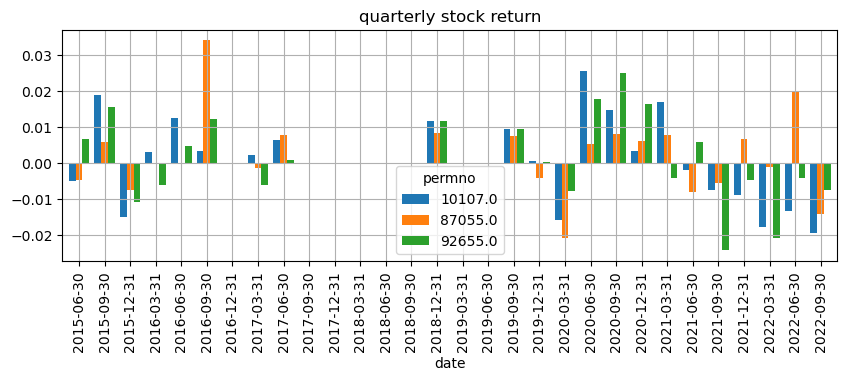

In [60]:
holdings_stk_focus['ret'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'quarterly stock return', width=0.8);

### weight

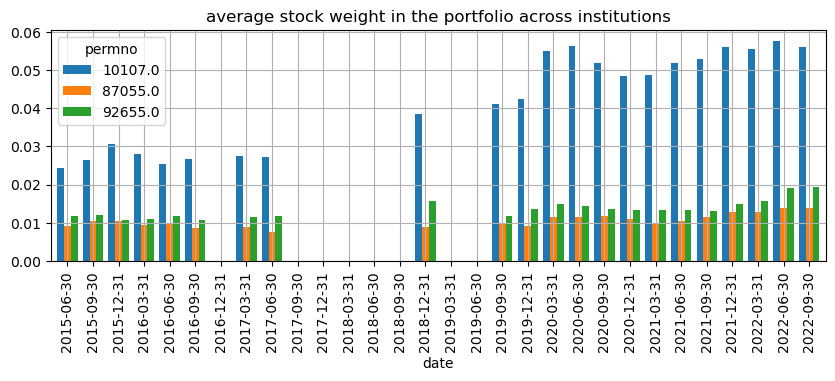

In [61]:
holdings_stk_focus['weight'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average stock weight in the portfolio across institutions', width=0.8);

<Axes: >

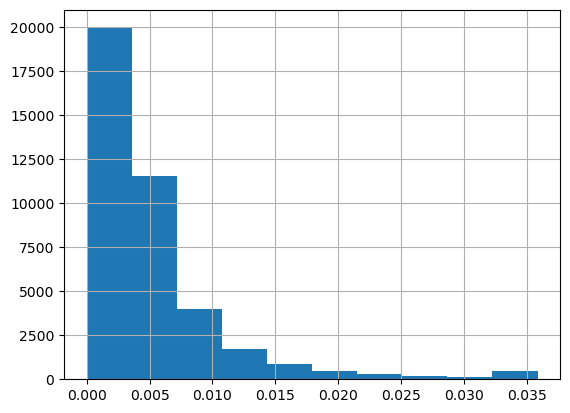

In [62]:
holdings_stk['weight'].clip(0, holdings_stk['weight'].quantile(0.99)).hist()

### weight_diff

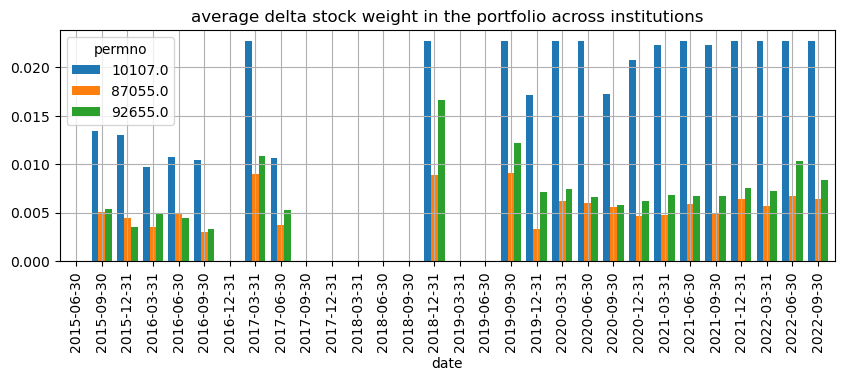

In [63]:
holdings_stk_focus['weight_diff'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average delta stock weight in the portfolio across institutions', width=0.8);

<Axes: >

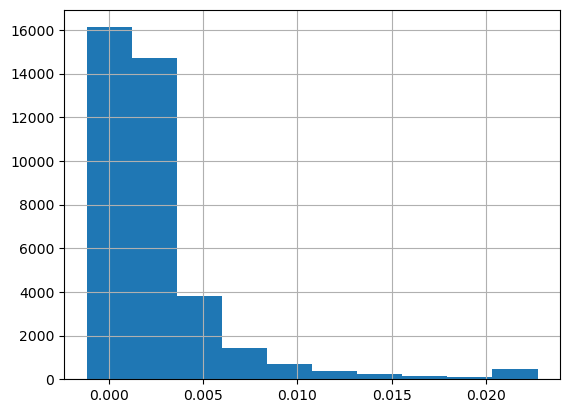

In [64]:
holdings_stk['weight_diff'].hist()

### buysale count

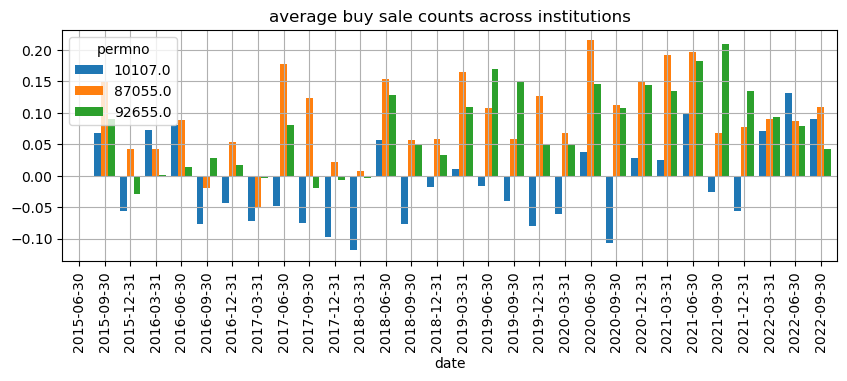

In [65]:
holdings_stk_focus['buysale'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'average buy sale counts across institutions', width=0.8);

<Axes: >

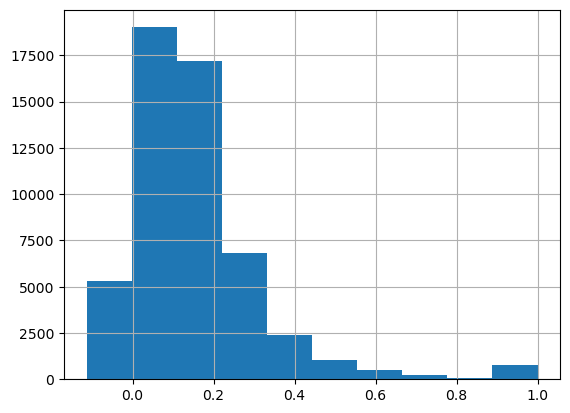

In [66]:
holdings_stk['buysale'].clip(holdings_stk['buysale'].quantile(0.01), holdings_stk['buysale'].quantile(0.99)).hist()

### mgrno_cnt_ratio_chg

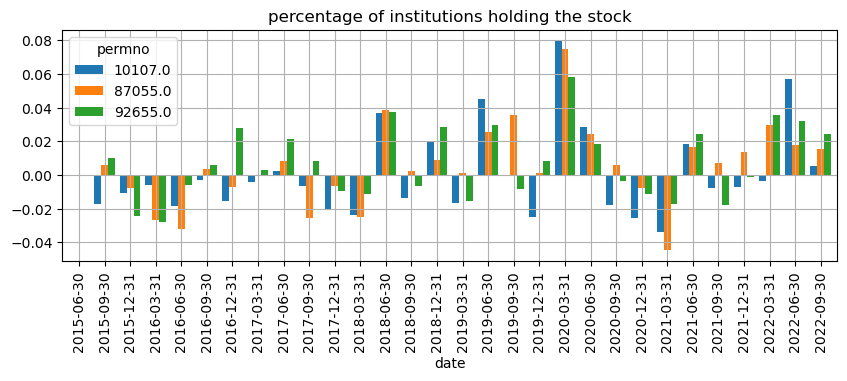

In [67]:
holdings_stk_focus['mgrno_cnt_ratio_chg'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'percentage of institutions holding the stock', width=0.8);

<Axes: >

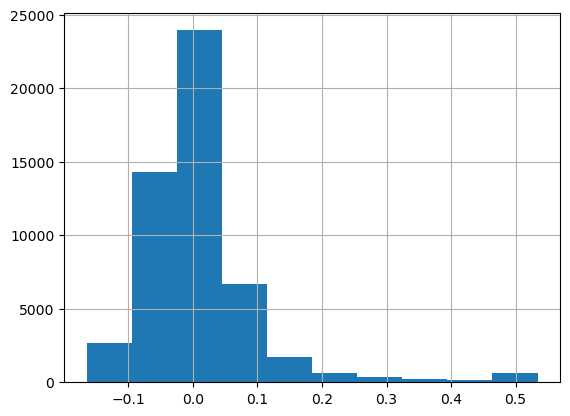

In [68]:
holdings_stk['mgrno_cnt_ratio_chg'].clip(holdings_stk['mgrno_cnt_ratio_chg'].quantile(0.01), holdings_stk['mgrno_cnt_ratio_chg'].quantile(0.99)).hist()

### value change

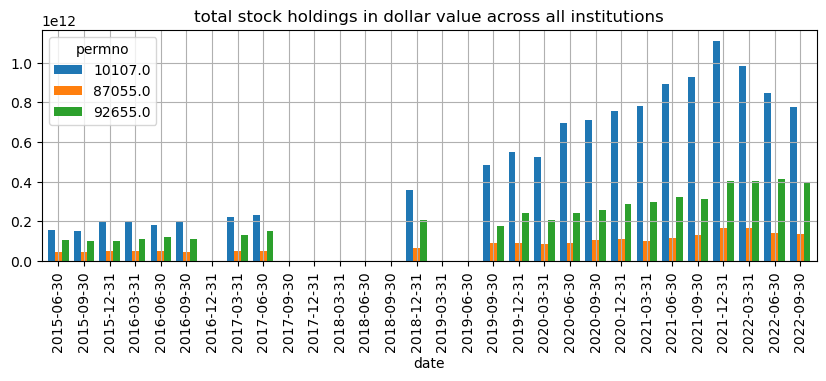

In [69]:
holdings_stk_focus['total_value'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'total stock holdings in dollar value across all institutions', width=0.8);

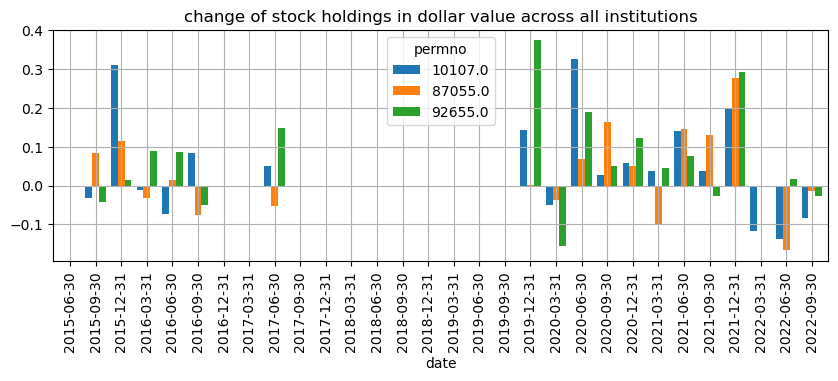

In [70]:
holdings_stk_focus['value_chg'].unstack().T.plot.bar(figsize = (10, 3), grid=True, title = 'change of stock holdings in dollar value across all institutions', width=0.8);

<Axes: >

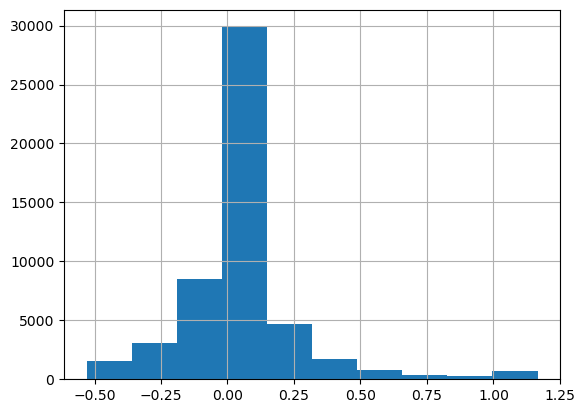

In [71]:
holdings_stk['value_chg'].clip(holdings_stk['value_chg'].quantile(0.01), holdings_stk['value_chg'].quantile(0.99)).hist()